In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = True
for layer in conv_base.layers[:-4]: # freeze all layers except last 4
    layer.trainable = False
conv_base.summary();

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)#(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [12]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

In [13]:
import random

def load_data(train_img_dir, test_img_dir):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=0.2,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [14]:
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.


In [15]:
from datetime import date
today = date.today()
date = today.strftime("%Y%m%d")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"{date}_fer_finetuning_vgg16_2.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=15)
]

print(f'Saving model as: {date}_fer_finetuning_vgg16.keras')
history = model.fit(x=train_dataset, epochs=60, validation_data=val_dataset, callbacks=callbacks)

Saving model as: 20230705_fer_finetuning_vgg16.keras
Epoch 1/60
7192/7192 [==============================] - 638s 88ms/step - loss: 1.5370 - accuracy: 0.5229 - val_loss: 1.2948 - val_accuracy: 0.6038
Epoch 2/60
7192/7192 [==============================] - 633s 88ms/step - loss: 1.2952 - accuracy: 0.5860 - val_loss: 1.1921 - val_accuracy: 0.6165
Epoch 3/60
7192/7192 [==============================] - 633s 88ms/step - loss: 1.2212 - accuracy: 0.6081 - val_loss: 1.1572 - val_accuracy: 0.6213
Epoch 4/60
7192/7192 [==============================] - 633s 88ms/step - loss: 1.1847 - accuracy: 0.6178 - val_loss: 1.1405 - val_accuracy: 0.6259
Epoch 5/60
7192/7192 [==============================] - 633s 88ms/step - loss: 1.1609 - accuracy: 0.6243 - val_loss: 1.1249 - val_accuracy: 0.6291
Epoch 6/60
7192/7192 [==============================] - 633s 88ms/step - loss: 1.1433 - accuracy: 0.6278 - val_loss: 1.1164 - val_accuracy: 0.6302
Epoch 7/60
7192/7192 [==============================] - 633s 88ms

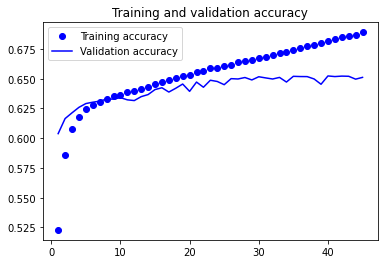

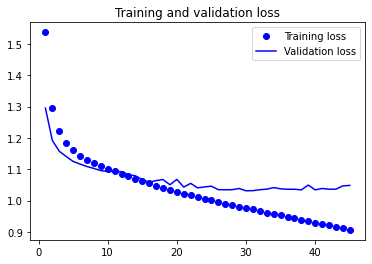

In [16]:
# complete dataset
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
# balanced & small dataset
model = keras.models.load_model(f"{date}_fer_finetuning_vgg16.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

500/500 [==============================] - 14s 27ms/step - loss: 1.6438 - accuracy: 0.3783
Test accuracy: 0.378


In [18]:
# complete dataset
model = keras.models.load_model(f"{date}_fer_finetuning_vgg16_2.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 10s 76ms/step - loss: 2.4670 - accuracy: 0.2458
Test accuracy: 0.246
